<a href="https://colab.research.google.com/github/rslab-ntua/ADRS-Python-Lab/blob/main/MSFA_DIP_demosaicing_Swthrhs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result.

In [ ]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./
!pip install rioxarray


Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (155/155), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 818.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 16.8 MB/s eta 0:00:00


In [2]:
!pip install ipyfilechooser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.8 MB/s eta 0:00:00


In [2]:
from ipyfilechooser import FileChooser
from google.colab import drive
import cv2
import numpy as np
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
fc = FileChooser("/content/drive")
display(fc)

FileChooser(path='/content/drive', filename='', title='', show_hidden=False, select_desc='Select', change_desc…

In [4]:
data_path = fc.selected_path #Folder Path
print (data_path)

/content/drive/MyDrive/MSFA


# Import libs

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
import rioxarray
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1
factor = 4 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8
# path_to_MSFA = 'data/MSFA/MSFA_Image_000014.tiff'
# path_to_MSMB = 'data/MSFA/multi_Image_000014.tiff'
# path_to_resized = 'data/MSFA/multi_Image_000014.tiff'
path_to_MSFA = 'data/MSFA/Butterfly.tiff'
path_to_merged = 'data/MSFA/Butterfly_merged.tiff'
path_to_resized = 'data/MSFA/multi_Batterfly_resized.tiff'


In [5]:
import cv2
import os


# Define the paths to the folders
parent_path = data_path
folders = ['MSFA', 'MultiSpectral', 'DOWNSCALED_FOR_COLAB']

# Extract filename parts from each folder
filename_parts = {}

for folder in folders:
    folder_path = os.path.join(parent_path, folder)
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    extracted_values = []
    for image in images:
        if folder == 'MSFA':
            extracted_values.append(image.split('.')[0])  # Extracting part before .tiff
        elif folder == 'MultiSpectral':
            extracted_values.append(image.split('_merged')[0])  # Extracting part before _merged
        elif folder == 'DOWNSCALED_FOR_COLAB':
            extracted_values.append(image.split('_down')[0])  # Extracting part before _down

    filename_parts[folder] = extracted_values

for folder, files in filename_parts.items():
    filename_parts[folder] = sorted(files)

# Function to create paths based on extracted filename parts
def create_paths(folder, parts, base_dir):
    if folder == 'MSFA':
        return [os.path.join(base_dir, folder, f"{part}.tiff") for part in parts]
    elif folder == 'MultiSpectral':
        return [os.path.join(base_dir, folder, f"{part}_merged.tiff") for part in parts]
    elif folder == 'DOWNSCALED_FOR_COLAB':
        return [os.path.join(base_dir, folder, f"{part}_down_merged.tiff") for part in parts]

# Creating paths for each folder using the extracted filename parts
path_to_MSFA = create_paths('MSFA', filename_parts['MSFA'], parent_path)
path_to_merged = create_paths('MultiSpectral', filename_parts['MultiSpectral'], parent_path)
path_to_resized = create_paths('DOWNSCALED_FOR_COLAB', filename_parts['DOWNSCALED_FOR_COLAB'], parent_path)
print(path_to_MSFA)
print(path_to_merged)
print(path_to_resized)

# Function to read TIFF images from paths using OpenCV
def read_images_from_paths(paths):
    images = [cv2.imread(path, cv2.IMREAD_UNCHANGED) for path in paths]
    return images

# Read TIFF images from the generated paths
MSFA_images = read_images_from_paths(path_to_MSFA)
merged_images = read_images_from_paths(path_to_merged)
resized_images = read_images_from_paths(path_to_resized)




['/content/drive/MyDrive/MSFA/MSFA/Butterfly.tiff', '/content/drive/MyDrive/MSFA/MSFA/Butterfly2.tiff', '/content/drive/MyDrive/MSFA/MSFA/Butterfly3.tiff', '/content/drive/MyDrive/MSFA/MSFA/Butterfly4.tiff', '/content/drive/MyDrive/MSFA/MSFA/Butterfly5.tiff', '/content/drive/MyDrive/MSFA/MSFA/Butterfly6.tiff', '/content/drive/MyDrive/MSFA/MSFA/Butterfly7.tiff', '/content/drive/MyDrive/MSFA/MSFA/Butterfly8.tiff', '/content/drive/MyDrive/MSFA/MSFA/CD.tiff', '/content/drive/MyDrive/MSFA/MSFA/Character.tiff', '/content/drive/MyDrive/MSFA/MSFA/Cloth.tiff', '/content/drive/MyDrive/MSFA/MSFA/Cloth2.tiff', '/content/drive/MyDrive/MSFA/MSFA/Cloth3.tiff', '/content/drive/MyDrive/MSFA/MSFA/Cloth4.tiff', '/content/drive/MyDrive/MSFA/MSFA/Cloth5.tiff', '/content/drive/MyDrive/MSFA/MSFA/Cloth6.tiff', '/content/drive/MyDrive/MSFA/MSFA/Color.tiff', '/content/drive/MyDrive/MSFA/MSFA/Colorchart.tiff', '/content/drive/MyDrive/MSFA/MSFA/Doll.tiff', '/content/drive/MyDrive/MSFA/MSFA/Fan.tiff', '/content/dr

KeyboardInterrupt: ignored

In [ ]:
image_merged = np.flipud(rioxarray.open_rasterio(
    path_to_merged,
).data.transpose([1,2,0])).transpose([2,0,1])

image_MSFA = rioxarray.open_rasterio(
    path_to_MSFA,
).data[0]

/usr/local/lib/python3.10/dist-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


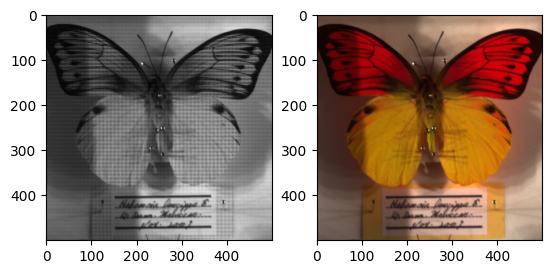

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image_MSFA, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(image_merged.transpose([1,2,0])[...,[2,1,3]])

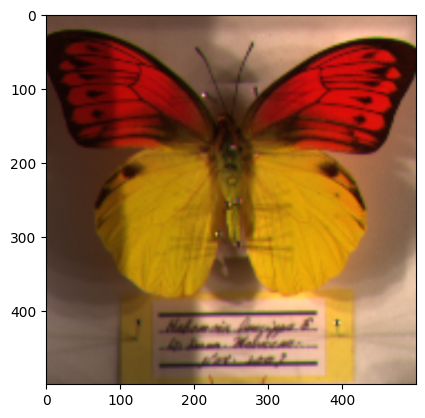

In [ ]:
image_merged_res = np.flipud(rioxarray.open_rasterio(
    'data/MSFA/multi_Butterfly_resized.tiff',
).data.transpose([1,2,0])).transpose([2,0,1])
plt.imshow(image_merged_res.transpose([1,2,0])[...,[1,3,2]])
# psnr_merged_int = peak_signal_noise_ratio(image_merged, image_merged_res)

# Load image and baselines

In [ ]:
# Starts here
# imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

# imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['MSFA_np'], imgs['merged_np'][...,0:3])

# if PLOT:
#     plot_image_grid([imgs['merged_np_show'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
#     print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
#                                         compare_psnr(imgs['HR_np'], imgs['bicubic_np']),
#                                         compare_psnr(imgs['HR_np'], imgs['nearest_np'])))

# Set up parameters and net

In [ ]:
class MSFAer(nn.Module):
    def __init__(self):
      super(MSFAer, self).__init__()

    def forward(self, input):
      tshape = input.shape
      # print(tshape)
      out = torch.zeros(size=(tshape[0],tshape[2],tshape[3])).type(dtype)
      out[:,0::3, 0::3]=input[:,0,0::3, 0::3]
      out[:,1::3, 0::3]=input[:,1,1::3, 0::3]
      out[:,2::3, 0::3]=input[:,2,2::3, 0::3]
      out[:,0::3, 1::3]=input[:,3,0::3, 1::3]
      out[:,0::3, 2::3]=input[:,4,0::3, 2::3]
      out[:,1::3, 1::3]=input[:,5,1::3, 1::3]
      out[:,1::3, 2::3]=input[:,6,1::3, 2::3]
      out[:,2::3, 1::3]=input[:,7,2::3, 1::3]
      out[:,2::3, 2::3]=input[:,8,2::3, 2::3]
      return out

In [ ]:
input_depth = 32

INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4:
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [ ]:
net_input = get_noise(input_depth, INPUT, (image_merged.shape[1], image_merged.shape[2])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128,
              skip_n33u=128,
              skip_n11=4,
              num_scales=4,
              n_channels=9,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_MSFA_var = np_to_torch(image_MSFA).type(dtype)

msfaer = MSFAer().type(dtype)

# Define closure and optimize

In [ ]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_full = net(net_input)
    # print("Network output shape", out_full.shape)
    out_MSFA = msfaer(out_full)
    # print(out_MSFA.shape, img_MSFA_var.shape)
    total_loss = mse(out_MSFA, img_MSFA_var)

    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_full)

    total_loss.backward()

    # Log
    psnr_MSFA = peak_signal_noise_ratio(image_MSFA, torch_to_np(out_MSFA))
    psnr_merged = peak_signal_noise_ratio(image_merged, torch_to_np(out_full))

    #print(psnr_MSFA)
    print ('Iteration %05d    PSNR_MSFA %.3f   PSNR_merged %.3f' % (i, psnr_MSFA, psnr_merged))

    # History
    psnr_history.append([psnr_MSFA, psnr_merged])

    if PLOT and i % 100 == 0:
        plt.figure("Output", [12, 4])
        plt.subplot(1,3,1)
        plt.imshow(image_merged.transpose([1,2,0])[...,[2,1,3]])
        plt.subplot(1,3,2)
        plt.imshow(torch_to_np(out_full).transpose([1,2,0])[...,[2,1,3]])
        plt.subplot(1,3,3)
        plt.imshow(image_merged_res.transpose([1,2,0])[...,[1,3,2]])
        plt.show()
        # out_HR_np = torch_to_np(out_HR)
        # plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)

    i += 1

    return total_loss

Starting optimization with ADAM


<ipython-input-28-b08d9281e9c9>:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_MSFA = peak_signal_noise_ratio(image_MSFA, torch_to_np(out_MSFA))
<ipython-input-28-b08d9281e9c9>:20: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_merged = peak_signal_noise_ratio(image_merged, torch_to_np(out_full))


Iteration 00000    PSNR_MSFA 27.655   PSNR_merged 27.606


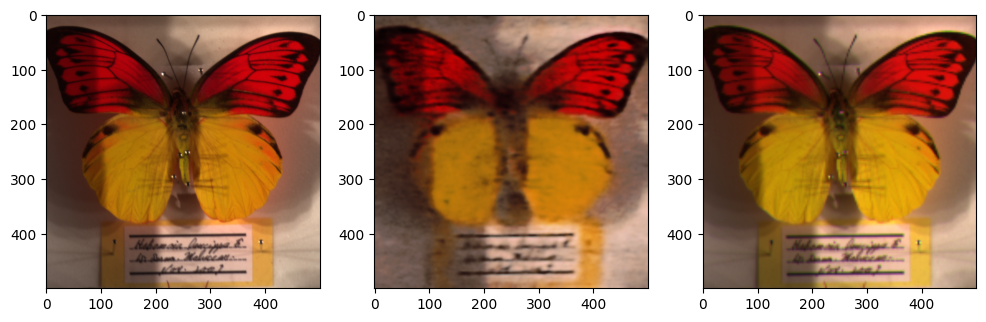

Iteration 00001    PSNR_MSFA 15.428   PSNR_merged 15.426
Iteration 00002    PSNR_MSFA 22.077   PSNR_merged 22.068
Iteration 00003    PSNR_MSFA 22.697   PSNR_merged 22.689
Iteration 00004    PSNR_MSFA 19.977   PSNR_merged 19.976
Iteration 00005    PSNR_MSFA 21.659   PSNR_merged 21.654
Iteration 00006    PSNR_MSFA 22.599   PSNR_merged 22.588
Iteration 00007    PSNR_MSFA 22.976   PSNR_merged 22.960
Iteration 00008    PSNR_MSFA 23.041   PSNR_merged 23.027
Iteration 00009    PSNR_MSFA 23.280   PSNR_merged 23.265
Iteration 00010    PSNR_MSFA 23.471   PSNR_merged 23.454
Iteration 00011    PSNR_MSFA 23.529   PSNR_merged 23.511
Iteration 00012    PSNR_MSFA 23.781   PSNR_merged 23.763
Iteration 00013    PSNR_MSFA 24.181   PSNR_merged 24.160
Iteration 00014    PSNR_MSFA 24.467   PSNR_merged 24.446
Iteration 00015    PSNR_MSFA 24.598   PSNR_merged 24.574
Iteration 00016    PSNR_MSFA 24.856   PSNR_merged 24.835
Iteration 00017    PSNR_MSFA 24.844   PSNR_merged 24.818
Iteration 00018    PSNR_MSFA 24

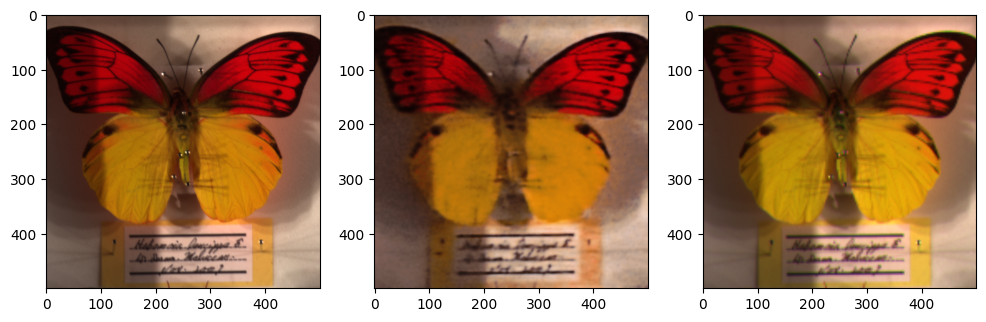

Iteration 00101    PSNR_MSFA 30.325   PSNR_merged 30.174
Iteration 00102    PSNR_MSFA 30.290   PSNR_merged 30.140
Iteration 00103    PSNR_MSFA 30.320   PSNR_merged 30.166
Iteration 00104    PSNR_MSFA 30.450   PSNR_merged 30.281
Iteration 00105    PSNR_MSFA 30.443   PSNR_merged 30.282
Iteration 00106    PSNR_MSFA 30.401   PSNR_merged 30.248
Iteration 00107    PSNR_MSFA 30.366   PSNR_merged 30.221
Iteration 00108    PSNR_MSFA 30.574   PSNR_merged 30.408
Iteration 00109    PSNR_MSFA 30.566   PSNR_merged 30.404
Iteration 00110    PSNR_MSFA 30.617   PSNR_merged 30.468
Iteration 00111    PSNR_MSFA 30.602   PSNR_merged 30.446
Iteration 00112    PSNR_MSFA 30.759   PSNR_merged 30.596
Iteration 00113    PSNR_MSFA 30.770   PSNR_merged 30.587
Iteration 00114    PSNR_MSFA 30.820   PSNR_merged 30.643
Iteration 00115    PSNR_MSFA 30.786   PSNR_merged 30.610
Iteration 00116    PSNR_MSFA 30.905   PSNR_merged 30.737
Iteration 00117    PSNR_MSFA 30.724   PSNR_merged 30.545
Iteration 00118    PSNR_MSFA 30

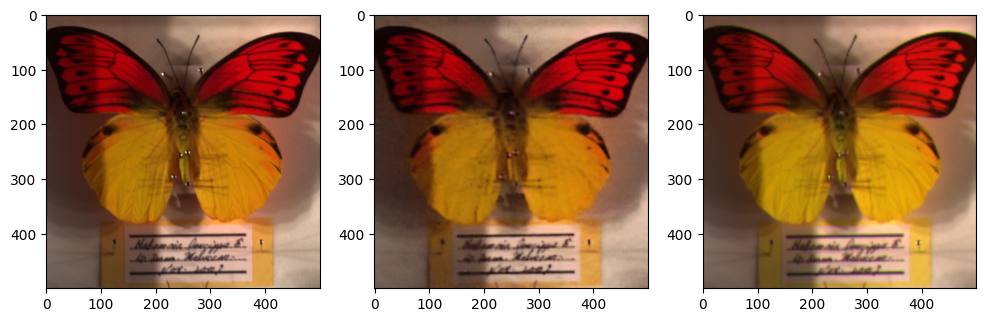

Iteration 00201    PSNR_MSFA 32.622   PSNR_merged 32.359
Iteration 00202    PSNR_MSFA 32.630   PSNR_merged 32.365
Iteration 00203    PSNR_MSFA 32.727   PSNR_merged 32.473
Iteration 00204    PSNR_MSFA 32.685   PSNR_merged 32.406
Iteration 00205    PSNR_MSFA 32.608   PSNR_merged 32.326
Iteration 00206    PSNR_MSFA 32.796   PSNR_merged 32.526
Iteration 00207    PSNR_MSFA 32.823   PSNR_merged 32.537
Iteration 00208    PSNR_MSFA 32.808   PSNR_merged 32.515
Iteration 00209    PSNR_MSFA 32.785   PSNR_merged 32.521
Iteration 00210    PSNR_MSFA 32.719   PSNR_merged 32.448
Iteration 00211    PSNR_MSFA 32.816   PSNR_merged 32.545
Iteration 00212    PSNR_MSFA 32.744   PSNR_merged 32.473
Iteration 00213    PSNR_MSFA 32.872   PSNR_merged 32.611
Iteration 00214    PSNR_MSFA 32.967   PSNR_merged 32.677
Iteration 00215    PSNR_MSFA 32.742   PSNR_merged 32.457
Iteration 00216    PSNR_MSFA 32.722   PSNR_merged 32.462
Iteration 00217    PSNR_MSFA 32.919   PSNR_merged 32.625
Iteration 00218    PSNR_MSFA 32

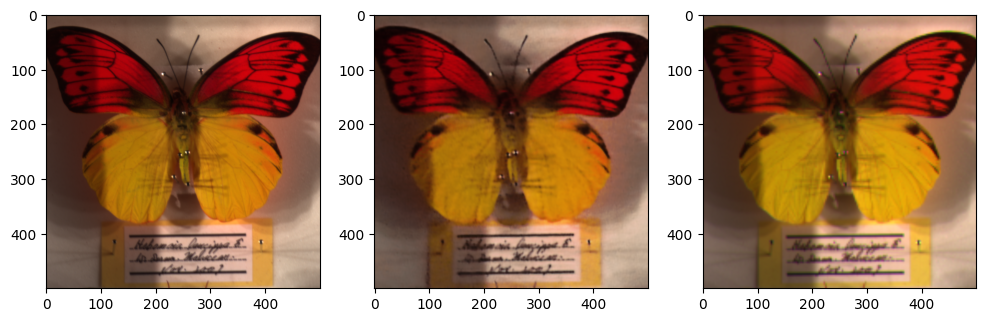

Iteration 00301    PSNR_MSFA 34.008   PSNR_merged 33.681
Iteration 00302    PSNR_MSFA 34.031   PSNR_merged 33.685
Iteration 00303    PSNR_MSFA 33.725   PSNR_merged 33.403
Iteration 00304    PSNR_MSFA 34.115   PSNR_merged 33.761
Iteration 00305    PSNR_MSFA 33.769   PSNR_merged 33.439
Iteration 00306    PSNR_MSFA 34.002   PSNR_merged 33.688
Iteration 00307    PSNR_MSFA 34.170   PSNR_merged 33.817
Iteration 00308    PSNR_MSFA 34.214   PSNR_merged 33.860
Iteration 00309    PSNR_MSFA 34.069   PSNR_merged 33.734
Iteration 00310    PSNR_MSFA 33.890   PSNR_merged 33.573
Iteration 00311    PSNR_MSFA 34.088   PSNR_merged 33.729
Iteration 00312    PSNR_MSFA 33.949   PSNR_merged 33.608
Iteration 00313    PSNR_MSFA 33.828   PSNR_merged 33.513
Iteration 00314    PSNR_MSFA 34.157   PSNR_merged 33.793
Iteration 00315    PSNR_MSFA 34.124   PSNR_merged 33.783
Iteration 00316    PSNR_MSFA 34.106   PSNR_merged 33.757
Iteration 00317    PSNR_MSFA 34.161   PSNR_merged 33.814
Iteration 00318    PSNR_MSFA 34

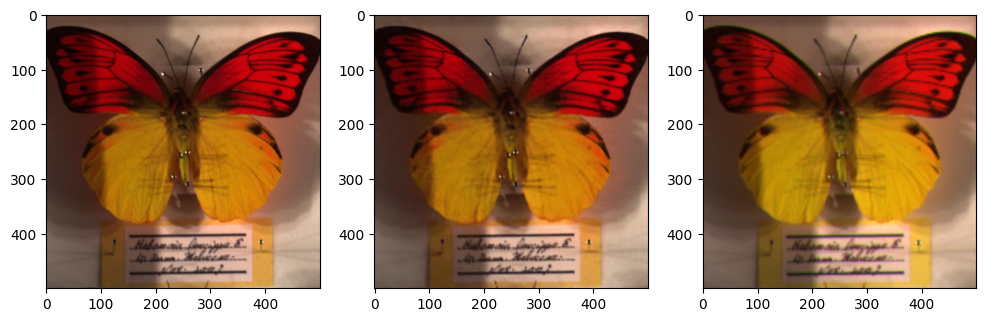

Iteration 00401    PSNR_MSFA 35.127   PSNR_merged 34.729
Iteration 00402    PSNR_MSFA 34.819   PSNR_merged 34.434
Iteration 00403    PSNR_MSFA 34.769   PSNR_merged 34.393
Iteration 00404    PSNR_MSFA 35.109   PSNR_merged 34.703
Iteration 00405    PSNR_MSFA 34.937   PSNR_merged 34.548
Iteration 00406    PSNR_MSFA 34.870   PSNR_merged 34.466
Iteration 00407    PSNR_MSFA 35.102   PSNR_merged 34.699
Iteration 00408    PSNR_MSFA 35.214   PSNR_merged 34.809
Iteration 00409    PSNR_MSFA 35.052   PSNR_merged 34.652
Iteration 00410    PSNR_MSFA 35.048   PSNR_merged 34.642
Iteration 00411    PSNR_MSFA 34.933   PSNR_merged 34.550
Iteration 00412    PSNR_MSFA 35.000   PSNR_merged 34.611
Iteration 00413    PSNR_MSFA 35.415   PSNR_merged 34.977
Iteration 00414    PSNR_MSFA 35.084   PSNR_merged 34.696
Iteration 00415    PSNR_MSFA 34.990   PSNR_merged 34.592
Iteration 00416    PSNR_MSFA 35.180   PSNR_merged 34.763
Iteration 00417    PSNR_MSFA 35.304   PSNR_merged 34.888
Iteration 00418    PSNR_MSFA 35

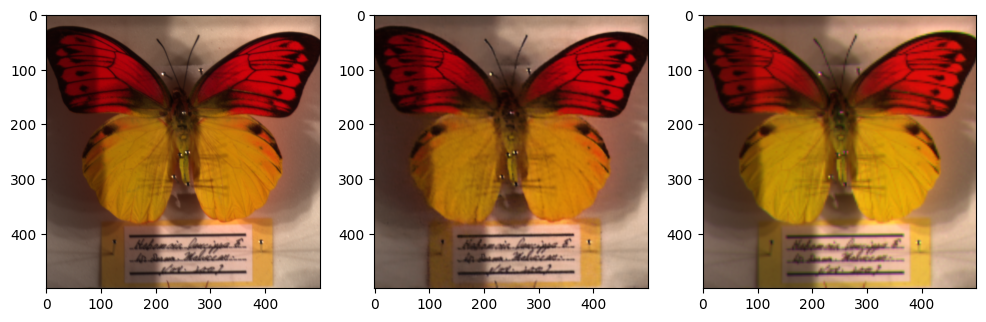

Iteration 00501    PSNR_MSFA 35.959   PSNR_merged 35.487
Iteration 00502    PSNR_MSFA 35.940   PSNR_merged 35.472
Iteration 00503    PSNR_MSFA 35.967   PSNR_merged 35.517
Iteration 00504    PSNR_MSFA 35.833   PSNR_merged 35.378
Iteration 00505    PSNR_MSFA 35.814   PSNR_merged 35.355
Iteration 00506    PSNR_MSFA 35.761   PSNR_merged 35.321
Iteration 00507    PSNR_MSFA 36.043   PSNR_merged 35.568
Iteration 00508    PSNR_MSFA 35.948   PSNR_merged 35.494
Iteration 00509    PSNR_MSFA 36.167   PSNR_merged 35.669
Iteration 00510    PSNR_MSFA 36.145   PSNR_merged 35.664
Iteration 00511    PSNR_MSFA 36.074   PSNR_merged 35.596
Iteration 00512    PSNR_MSFA 36.099   PSNR_merged 35.619
Iteration 00513    PSNR_MSFA 36.143   PSNR_merged 35.669
Iteration 00514    PSNR_MSFA 35.979   PSNR_merged 35.514
Iteration 00515    PSNR_MSFA 36.062   PSNR_merged 35.610
Iteration 00516    PSNR_MSFA 36.164   PSNR_merged 35.693
Iteration 00517    PSNR_MSFA 35.860   PSNR_merged 35.404
Iteration 00518    PSNR_MSFA 36

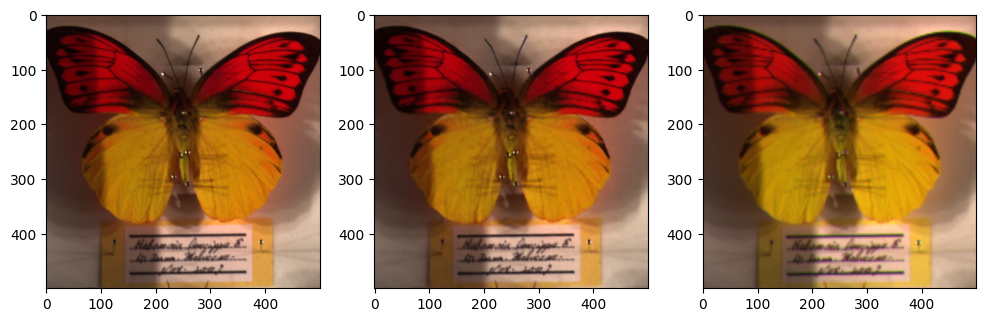

Iteration 00601    PSNR_MSFA 36.360   PSNR_merged 35.875
Iteration 00602    PSNR_MSFA 36.256   PSNR_merged 35.788
Iteration 00603    PSNR_MSFA 36.484   PSNR_merged 36.011
Iteration 00604    PSNR_MSFA 36.484   PSNR_merged 35.977
Iteration 00605    PSNR_MSFA 36.606   PSNR_merged 36.119
Iteration 00606    PSNR_MSFA 36.338   PSNR_merged 35.868
Iteration 00607    PSNR_MSFA 36.352   PSNR_merged 35.868
Iteration 00608    PSNR_MSFA 36.621   PSNR_merged 36.121
Iteration 00609    PSNR_MSFA 36.546   PSNR_merged 36.060
Iteration 00610    PSNR_MSFA 36.670   PSNR_merged 36.153
Iteration 00611    PSNR_MSFA 36.743   PSNR_merged 36.239
Iteration 00612    PSNR_MSFA 36.615   PSNR_merged 36.107
Iteration 00613    PSNR_MSFA 36.640   PSNR_merged 36.109
Iteration 00614    PSNR_MSFA 36.439   PSNR_merged 35.960
Iteration 00615    PSNR_MSFA 36.531   PSNR_merged 36.032
Iteration 00616    PSNR_MSFA 36.547   PSNR_merged 36.043
Iteration 00617    PSNR_MSFA 36.649   PSNR_merged 36.151
Iteration 00618    PSNR_MSFA 36

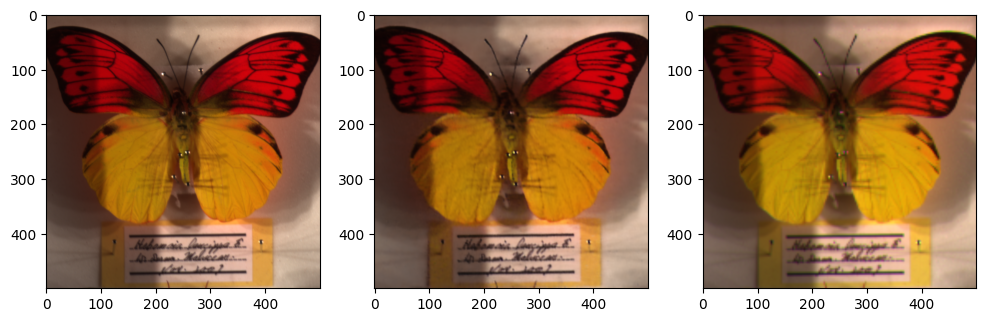

Iteration 00701    PSNR_MSFA 36.915   PSNR_merged 36.401
Iteration 00702    PSNR_MSFA 36.881   PSNR_merged 36.358
Iteration 00703    PSNR_MSFA 36.920   PSNR_merged 36.403
Iteration 00704    PSNR_MSFA 36.904   PSNR_merged 36.384
Iteration 00705    PSNR_MSFA 36.968   PSNR_merged 36.443
Iteration 00706    PSNR_MSFA 37.012   PSNR_merged 36.506
Iteration 00707    PSNR_MSFA 37.006   PSNR_merged 36.500
Iteration 00708    PSNR_MSFA 37.268   PSNR_merged 36.719
Iteration 00709    PSNR_MSFA 37.049   PSNR_merged 36.521
Iteration 00710    PSNR_MSFA 36.980   PSNR_merged 36.448
Iteration 00711    PSNR_MSFA 37.095   PSNR_merged 36.557
Iteration 00712    PSNR_MSFA 37.007   PSNR_merged 36.492
Iteration 00713    PSNR_MSFA 37.126   PSNR_merged 36.599
Iteration 00714    PSNR_MSFA 36.748   PSNR_merged 36.249
Iteration 00715    PSNR_MSFA 37.164   PSNR_merged 36.612
Iteration 00716    PSNR_MSFA 37.050   PSNR_merged 36.533
Iteration 00717    PSNR_MSFA 36.828   PSNR_merged 36.337
Iteration 00718    PSNR_MSFA 37

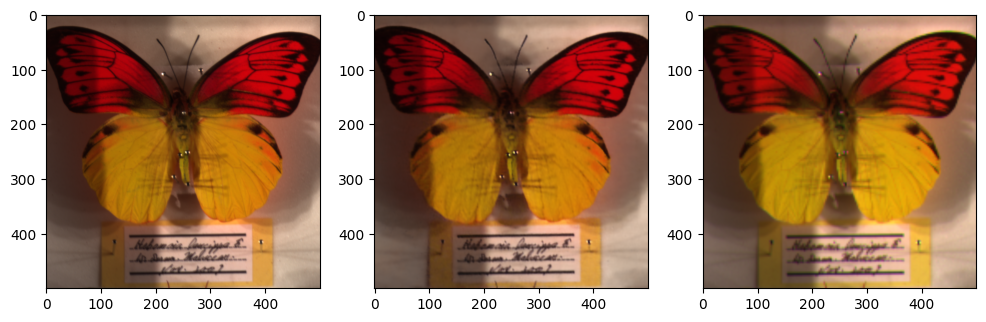

Iteration 00801    PSNR_MSFA 37.270   PSNR_merged 36.742
Iteration 00802    PSNR_MSFA 36.775   PSNR_merged 36.299
Iteration 00803    PSNR_MSFA 37.057   PSNR_merged 36.535
Iteration 00804    PSNR_MSFA 37.611   PSNR_merged 37.024
Iteration 00805    PSNR_MSFA 37.156   PSNR_merged 36.619
Iteration 00806    PSNR_MSFA 36.797   PSNR_merged 36.324
Iteration 00807    PSNR_MSFA 37.648   PSNR_merged 37.048
Iteration 00808    PSNR_MSFA 37.072   PSNR_merged 36.570
Iteration 00809    PSNR_MSFA 37.287   PSNR_merged 36.752
Iteration 00810    PSNR_MSFA 37.450   PSNR_merged 36.890
Iteration 00811    PSNR_MSFA 37.551   PSNR_merged 36.961
Iteration 00812    PSNR_MSFA 37.350   PSNR_merged 36.799
Iteration 00813    PSNR_MSFA 37.626   PSNR_merged 37.030
Iteration 00814    PSNR_MSFA 37.622   PSNR_merged 37.029
Iteration 00815    PSNR_MSFA 37.113   PSNR_merged 36.596
Iteration 00816    PSNR_MSFA 37.248   PSNR_merged 36.725
Iteration 00817    PSNR_MSFA 37.648   PSNR_merged 37.072
Iteration 00818    PSNR_MSFA 37

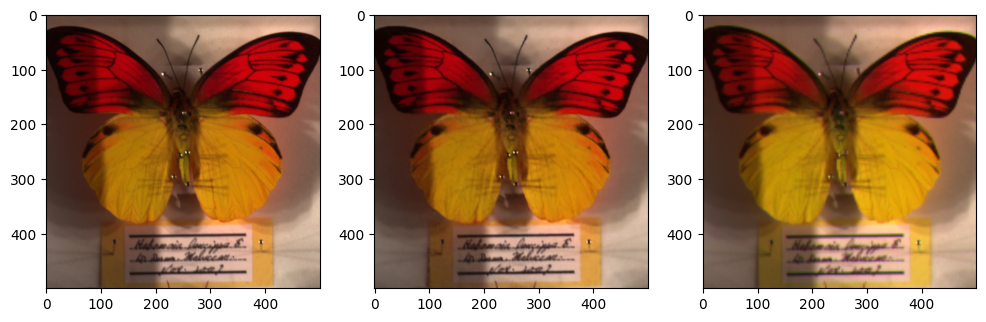

Iteration 00901    PSNR_MSFA 37.776   PSNR_merged 37.217
Iteration 00902    PSNR_MSFA 37.983   PSNR_merged 37.370
Iteration 00903    PSNR_MSFA 38.092   PSNR_merged 37.462
Iteration 00904    PSNR_MSFA 37.917   PSNR_merged 37.331
Iteration 00905    PSNR_MSFA 37.889   PSNR_merged 37.274
Iteration 00906    PSNR_MSFA 37.907   PSNR_merged 37.285
Iteration 00907    PSNR_MSFA 37.819   PSNR_merged 37.227
Iteration 00908    PSNR_MSFA 37.921   PSNR_merged 37.297
Iteration 00909    PSNR_MSFA 37.831   PSNR_merged 37.224
Iteration 00910    PSNR_MSFA 37.954   PSNR_merged 37.338
Iteration 00911    PSNR_MSFA 37.905   PSNR_merged 37.287
Iteration 00912    PSNR_MSFA 37.988   PSNR_merged 37.368
Iteration 00913    PSNR_MSFA 38.030   PSNR_merged 37.382
Iteration 00914    PSNR_MSFA 38.057   PSNR_merged 37.425
Iteration 00915    PSNR_MSFA 38.085   PSNR_merged 37.449
Iteration 00916    PSNR_MSFA 37.989   PSNR_merged 37.389
Iteration 00917    PSNR_MSFA 38.212   PSNR_merged 37.582
Iteration 00918    PSNR_MSFA 38

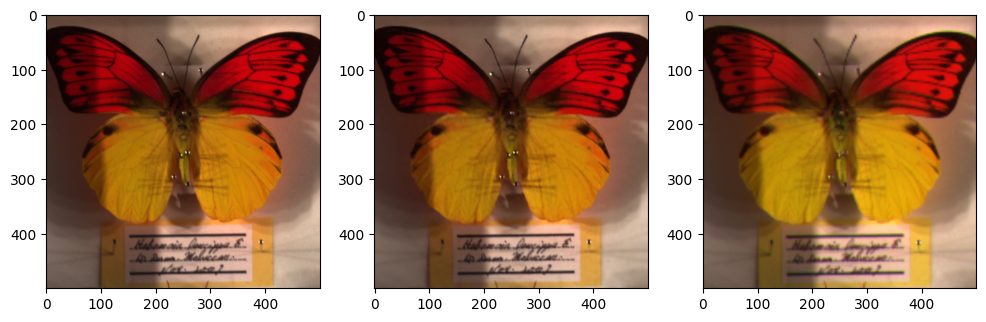

Iteration 01001    PSNR_MSFA 37.628   PSNR_merged 37.049
Iteration 01002    PSNR_MSFA 38.329   PSNR_merged 37.671
Iteration 01003    PSNR_MSFA 38.074   PSNR_merged 37.438
Iteration 01004    PSNR_MSFA 37.978   PSNR_merged 37.339
Iteration 01005    PSNR_MSFA 38.380   PSNR_merged 37.700
Iteration 01006    PSNR_MSFA 38.174   PSNR_merged 37.506
Iteration 01007    PSNR_MSFA 38.145   PSNR_merged 37.494
Iteration 01008    PSNR_MSFA 38.230   PSNR_merged 37.575
Iteration 01009    PSNR_MSFA 38.276   PSNR_merged 37.614
Iteration 01010    PSNR_MSFA 38.038   PSNR_merged 37.425
Iteration 01011    PSNR_MSFA 38.203   PSNR_merged 37.554
Iteration 01012    PSNR_MSFA 38.379   PSNR_merged 37.703
Iteration 01013    PSNR_MSFA 38.200   PSNR_merged 37.561
Iteration 01014    PSNR_MSFA 38.564   PSNR_merged 37.871
Iteration 01015    PSNR_MSFA 38.335   PSNR_merged 37.683
Iteration 01016    PSNR_MSFA 38.282   PSNR_merged 37.631
Iteration 01017    PSNR_MSFA 38.422   PSNR_merged 37.729
Iteration 01018    PSNR_MSFA 38

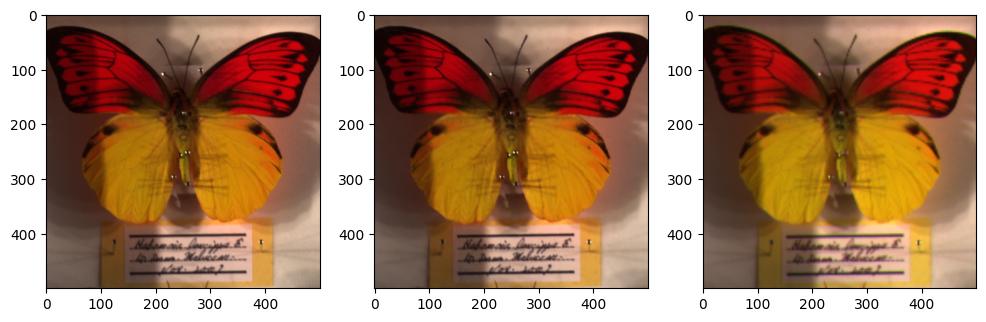

Iteration 01101    PSNR_MSFA 38.729   PSNR_merged 38.010
Iteration 01102    PSNR_MSFA 38.718   PSNR_merged 37.977
Iteration 01103    PSNR_MSFA 38.715   PSNR_merged 38.004
Iteration 01104    PSNR_MSFA 38.666   PSNR_merged 37.933
Iteration 01105    PSNR_MSFA 38.749   PSNR_merged 38.025
Iteration 01106    PSNR_MSFA 38.845   PSNR_merged 38.081
Iteration 01107    PSNR_MSFA 38.874   PSNR_merged 38.120
Iteration 01108    PSNR_MSFA 38.900   PSNR_merged 38.159
Iteration 01109    PSNR_MSFA 38.699   PSNR_merged 37.993
Iteration 01110    PSNR_MSFA 38.850   PSNR_merged 38.113
Iteration 01111    PSNR_MSFA 38.715   PSNR_merged 37.995
Iteration 01112    PSNR_MSFA 38.518   PSNR_merged 37.845
Iteration 01113    PSNR_MSFA 38.880   PSNR_merged 38.140
Iteration 01114    PSNR_MSFA 38.558   PSNR_merged 37.856
Iteration 01115    PSNR_MSFA 38.096   PSNR_merged 37.463
Iteration 01116    PSNR_MSFA 38.314   PSNR_merged 37.655
Iteration 01117    PSNR_MSFA 38.949   PSNR_merged 38.196
Iteration 01118    PSNR_MSFA 38

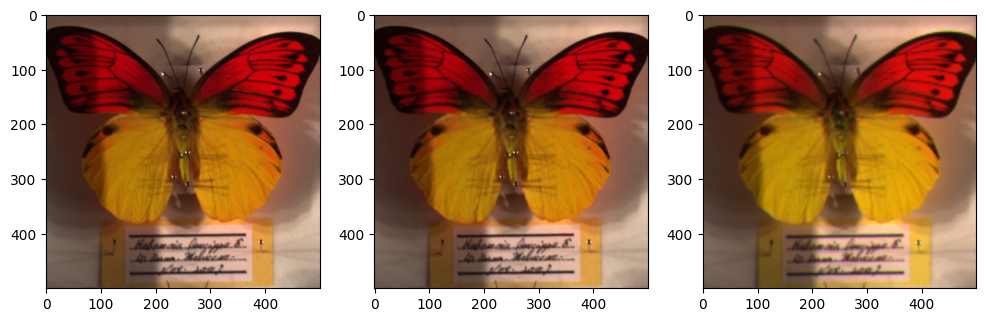

Iteration 01201    PSNR_MSFA 38.889   PSNR_merged 38.152
Iteration 01202    PSNR_MSFA 39.090   PSNR_merged 38.294
Iteration 01203    PSNR_MSFA 38.922   PSNR_merged 38.162
Iteration 01204    PSNR_MSFA 38.983   PSNR_merged 38.215
Iteration 01205    PSNR_MSFA 38.891   PSNR_merged 38.119
Iteration 01206    PSNR_MSFA 39.111   PSNR_merged 38.320
Iteration 01207    PSNR_MSFA 38.893   PSNR_merged 38.141
Iteration 01208    PSNR_MSFA 39.006   PSNR_merged 38.215
Iteration 01209    PSNR_MSFA 39.251   PSNR_merged 38.435
Iteration 01210    PSNR_MSFA 38.963   PSNR_merged 38.205
Iteration 01211    PSNR_MSFA 39.042   PSNR_merged 38.277
Iteration 01212    PSNR_MSFA 39.173   PSNR_merged 38.373
Iteration 01213    PSNR_MSFA 38.955   PSNR_merged 38.193
Iteration 01214    PSNR_MSFA 38.863   PSNR_merged 38.105
Iteration 01215    PSNR_MSFA 39.143   PSNR_merged 38.352
Iteration 01216    PSNR_MSFA 39.092   PSNR_merged 38.293
Iteration 01217    PSNR_MSFA 38.787   PSNR_merged 38.030
Iteration 01218    PSNR_MSFA 39

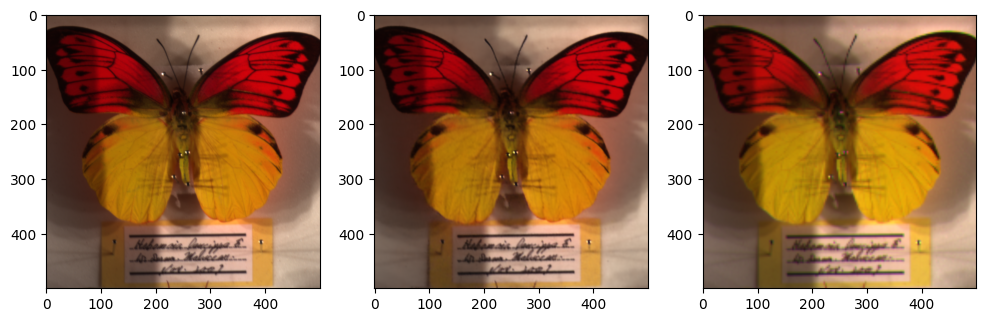

Iteration 01301    PSNR_MSFA 39.199   PSNR_merged 38.386
Iteration 01302    PSNR_MSFA 39.313   PSNR_merged 38.490
Iteration 01303    PSNR_MSFA 39.131   PSNR_merged 38.355
Iteration 01304    PSNR_MSFA 39.336   PSNR_merged 38.490
Iteration 01305    PSNR_MSFA 38.967   PSNR_merged 38.194
Iteration 01306    PSNR_MSFA 39.034   PSNR_merged 38.251
Iteration 01307    PSNR_MSFA 39.372   PSNR_merged 38.523
Iteration 01308    PSNR_MSFA 39.007   PSNR_merged 38.221
Iteration 01309    PSNR_MSFA 38.918   PSNR_merged 38.157
Iteration 01310    PSNR_MSFA 39.058   PSNR_merged 38.265
Iteration 01311    PSNR_MSFA 39.128   PSNR_merged 38.297
Iteration 01312    PSNR_MSFA 39.055   PSNR_merged 38.271
Iteration 01313    PSNR_MSFA 39.123   PSNR_merged 38.316
Iteration 01314    PSNR_MSFA 39.176   PSNR_merged 38.357
Iteration 01315    PSNR_MSFA 39.404   PSNR_merged 38.560
Iteration 01316    PSNR_MSFA 39.515   PSNR_merged 38.646
Iteration 01317    PSNR_MSFA 39.510   PSNR_merged 38.654
Iteration 01318    PSNR_MSFA 38

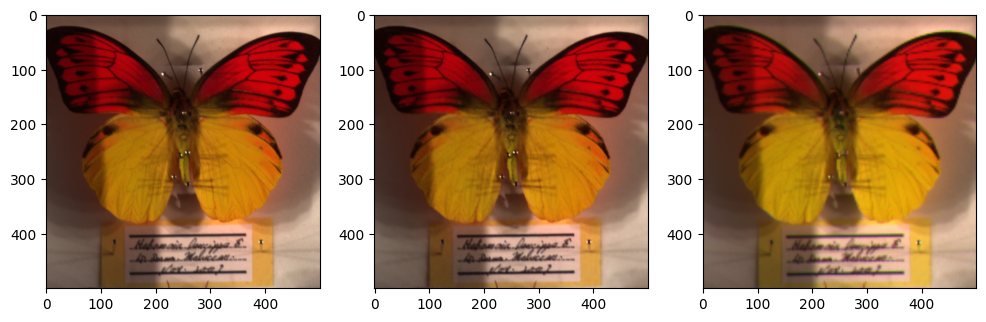

Iteration 01401    PSNR_MSFA 39.079   PSNR_merged 38.258
Iteration 01402    PSNR_MSFA 39.184   PSNR_merged 38.354
Iteration 01403    PSNR_MSFA 39.505   PSNR_merged 38.643
Iteration 01404    PSNR_MSFA 39.641   PSNR_merged 38.744
Iteration 01405    PSNR_MSFA 39.301   PSNR_merged 38.448
Iteration 01406    PSNR_MSFA 39.156   PSNR_merged 38.332
Iteration 01407    PSNR_MSFA 39.440   PSNR_merged 38.582
Iteration 01408    PSNR_MSFA 39.563   PSNR_merged 38.683
Iteration 01409    PSNR_MSFA 39.643   PSNR_merged 38.758
Iteration 01410    PSNR_MSFA 39.649   PSNR_merged 38.766
Iteration 01411    PSNR_MSFA 39.458   PSNR_merged 38.592
Iteration 01412    PSNR_MSFA 39.545   PSNR_merged 38.666
Iteration 01413    PSNR_MSFA 39.504   PSNR_merged 38.625
Iteration 01414    PSNR_MSFA 39.720   PSNR_merged 38.796
Iteration 01415    PSNR_MSFA 39.480   PSNR_merged 38.602
Iteration 01416    PSNR_MSFA 39.456   PSNR_merged 38.546
Iteration 01417    PSNR_MSFA 39.649   PSNR_merged 38.744
Iteration 01418    PSNR_MSFA 39

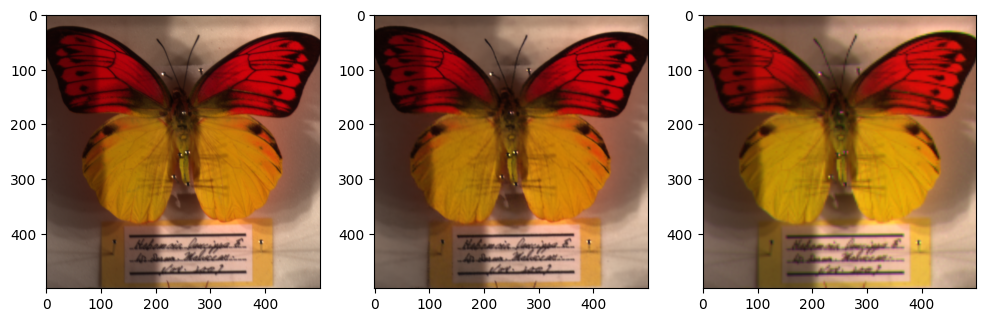

Iteration 01501    PSNR_MSFA 39.313   PSNR_merged 38.459
Iteration 01502    PSNR_MSFA 39.770   PSNR_merged 38.830
Iteration 01503    PSNR_MSFA 39.581   PSNR_merged 38.664
Iteration 01504    PSNR_MSFA 39.320   PSNR_merged 38.491
Iteration 01505    PSNR_MSFA 39.355   PSNR_merged 38.511
Iteration 01506    PSNR_MSFA 39.220   PSNR_merged 38.390
Iteration 01507    PSNR_MSFA 39.475   PSNR_merged 38.599
Iteration 01508    PSNR_MSFA 39.708   PSNR_merged 38.807
Iteration 01509    PSNR_MSFA 39.202   PSNR_merged 38.376
Iteration 01510    PSNR_MSFA 39.108   PSNR_merged 38.307
Iteration 01511    PSNR_MSFA 39.493   PSNR_merged 38.605
Iteration 01512    PSNR_MSFA 39.520   PSNR_merged 38.604
Iteration 01513    PSNR_MSFA 39.309   PSNR_merged 38.463
Iteration 01514    PSNR_MSFA 39.069   PSNR_merged 38.234
Iteration 01515    PSNR_MSFA 39.567   PSNR_merged 38.673
Iteration 01516    PSNR_MSFA 39.748   PSNR_merged 38.817
Iteration 01517    PSNR_MSFA 39.391   PSNR_merged 38.508
Iteration 01518    PSNR_MSFA 39

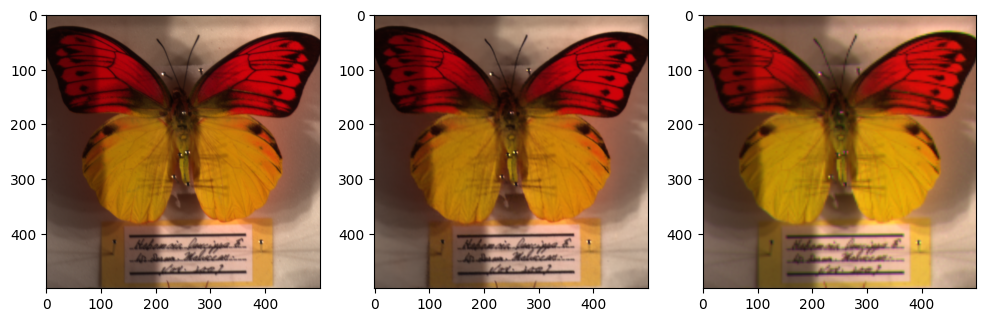

Iteration 01601    PSNR_MSFA 39.591   PSNR_merged 38.686
Iteration 01602    PSNR_MSFA 39.955   PSNR_merged 38.967
Iteration 01603    PSNR_MSFA 39.913   PSNR_merged 38.950
Iteration 01604    PSNR_MSFA 39.627   PSNR_merged 38.716
Iteration 01605    PSNR_MSFA 39.554   PSNR_merged 38.692
Iteration 01606    PSNR_MSFA 39.988   PSNR_merged 39.017
Iteration 01607    PSNR_MSFA 39.839   PSNR_merged 38.892
Iteration 01608    PSNR_MSFA 39.533   PSNR_merged 38.636
Iteration 01609    PSNR_MSFA 40.092   PSNR_merged 39.079
Iteration 01610    PSNR_MSFA 39.868   PSNR_merged 38.898
Iteration 01611    PSNR_MSFA 39.835   PSNR_merged 38.877
Iteration 01612    PSNR_MSFA 40.076   PSNR_merged 39.044
Iteration 01613    PSNR_MSFA 39.942   PSNR_merged 38.955
Iteration 01614    PSNR_MSFA 39.935   PSNR_merged 38.954
Iteration 01615    PSNR_MSFA 39.892   PSNR_merged 38.904
Iteration 01616    PSNR_MSFA 40.037   PSNR_merged 39.021
Iteration 01617    PSNR_MSFA 39.742   PSNR_merged 38.801
Iteration 01618    PSNR_MSFA 39

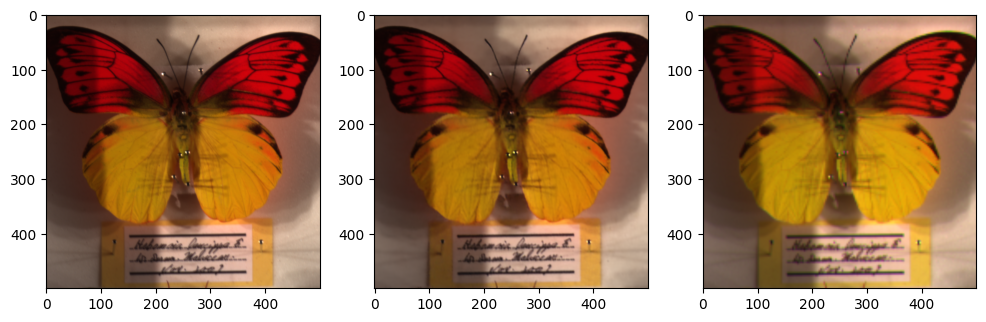

Iteration 01701    PSNR_MSFA 40.218   PSNR_merged 39.192
Iteration 01702    PSNR_MSFA 39.927   PSNR_merged 38.951
Iteration 01703    PSNR_MSFA 40.250   PSNR_merged 39.214
Iteration 01704    PSNR_MSFA 40.169   PSNR_merged 39.148
Iteration 01705    PSNR_MSFA 39.962   PSNR_merged 38.988
Iteration 01706    PSNR_MSFA 40.129   PSNR_merged 39.105
Iteration 01707    PSNR_MSFA 40.263   PSNR_merged 39.234
Iteration 01708    PSNR_MSFA 40.292   PSNR_merged 39.225
Iteration 01709    PSNR_MSFA 40.359   PSNR_merged 39.271
Iteration 01710    PSNR_MSFA 40.255   PSNR_merged 39.217
Iteration 01711    PSNR_MSFA 40.341   PSNR_merged 39.305
Iteration 01712    PSNR_MSFA 40.327   PSNR_merged 39.245
Iteration 01713    PSNR_MSFA 40.394   PSNR_merged 39.326
Iteration 01714    PSNR_MSFA 40.197   PSNR_merged 39.180
Iteration 01715    PSNR_MSFA 40.492   PSNR_merged 39.396
Iteration 01716    PSNR_MSFA 40.382   PSNR_merged 39.316
Iteration 01717    PSNR_MSFA 40.320   PSNR_merged 39.241
Iteration 01718    PSNR_MSFA 40

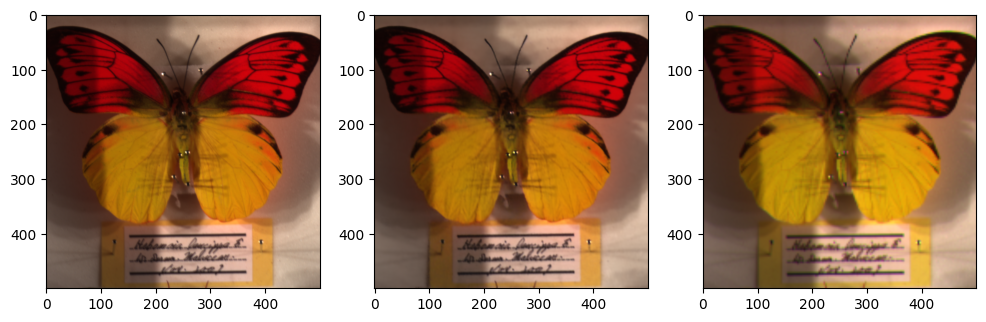

Iteration 01801    PSNR_MSFA 40.498   PSNR_merged 39.394
Iteration 01802    PSNR_MSFA 39.987   PSNR_merged 38.979
Iteration 01803    PSNR_MSFA 39.642   PSNR_merged 38.702
Iteration 01804    PSNR_MSFA 39.920   PSNR_merged 38.923
Iteration 01805    PSNR_MSFA 40.373   PSNR_merged 39.284
Iteration 01806    PSNR_MSFA 40.255   PSNR_merged 39.173
Iteration 01807    PSNR_MSFA 39.852   PSNR_merged 38.861
Iteration 01808    PSNR_MSFA 40.272   PSNR_merged 39.191
Iteration 01809    PSNR_MSFA 40.279   PSNR_merged 39.192
Iteration 01810    PSNR_MSFA 39.855   PSNR_merged 38.857
Iteration 01811    PSNR_MSFA 39.832   PSNR_merged 38.873
Iteration 01812    PSNR_MSFA 40.086   PSNR_merged 39.077
Iteration 01813    PSNR_MSFA 40.297   PSNR_merged 39.198
Iteration 01814    PSNR_MSFA 40.051   PSNR_merged 39.002
Iteration 01815    PSNR_MSFA 40.097   PSNR_merged 39.058
Iteration 01816    PSNR_MSFA 40.186   PSNR_merged 39.069
Iteration 01817    PSNR_MSFA 40.269   PSNR_merged 39.185
Iteration 01818    PSNR_MSFA 40

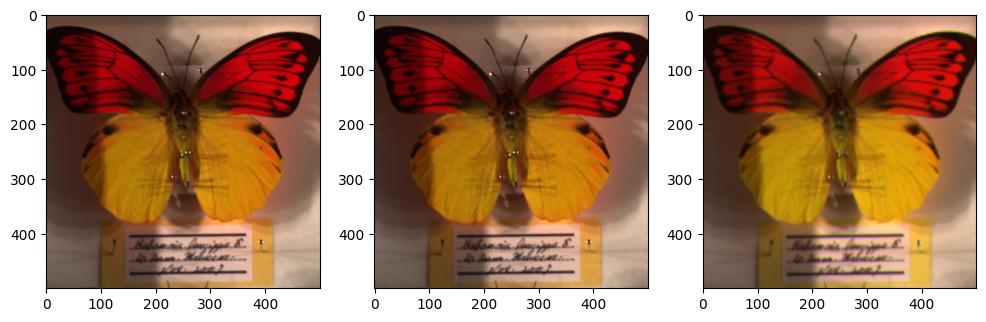

Iteration 01901    PSNR_MSFA 40.564   PSNR_merged 39.402
Iteration 01902    PSNR_MSFA 40.410   PSNR_merged 39.313
Iteration 01903    PSNR_MSFA 40.537   PSNR_merged 39.408
Iteration 01904    PSNR_MSFA 40.347   PSNR_merged 39.261
Iteration 01905    PSNR_MSFA 40.440   PSNR_merged 39.341
Iteration 01906    PSNR_MSFA 40.513   PSNR_merged 39.382
Iteration 01907    PSNR_MSFA 40.033   PSNR_merged 38.990
Iteration 01908    PSNR_MSFA 40.325   PSNR_merged 39.231
Iteration 01909    PSNR_MSFA 40.644   PSNR_merged 39.477
Iteration 01910    PSNR_MSFA 40.108   PSNR_merged 39.080
Iteration 01911    PSNR_MSFA 40.136   PSNR_merged 39.051
Iteration 01912    PSNR_MSFA 40.307   PSNR_merged 39.214
Iteration 01913    PSNR_MSFA 40.188   PSNR_merged 39.141
Iteration 01914    PSNR_MSFA 40.222   PSNR_merged 39.145
Iteration 01915    PSNR_MSFA 40.540   PSNR_merged 39.394
Iteration 01916    PSNR_MSFA 40.330   PSNR_merged 39.235
Iteration 01917    PSNR_MSFA 40.522   PSNR_merged 39.372
Iteration 01918    PSNR_MSFA 40

In [ ]:
psnr_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

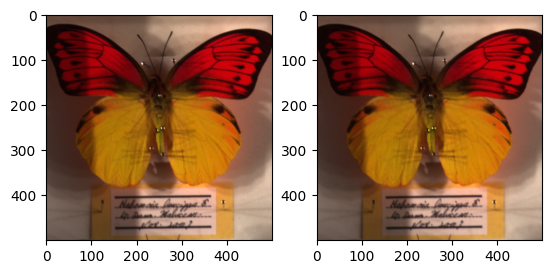

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image_merged.transpose([1,2,0])[...,[2,1,3]])
plt.subplot(1,2,2)
plt.imshow(np.clip(torch_to_np(net(net_input)), 0, 1).transpose([1,2,0])[...,[2,1,3]])
plt.show()

In [ ]:

out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);